In [1]:
from os import system as bash
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import TimestampType
from datetime import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
import pickle
import time

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
splice = PySpliceContext(spark)

In [3]:
SCHEMA = 'AGUPTA'
TABLE = 'january'

In [4]:
mmsi_freq = pd.read_pickle('Processed_Data/mmsi_freq.pkl')

In [21]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def load_data(filename):
    a_file = open(filename, "rb")
    output = pickle.load(a_file)
    a_file.close()
    
    return output

def save_data(filename, data):
    a_file = open(filename, "wb")
    pickle.dump(data, a_file)
    a_file.close()

In [5]:
def get_location(my_df):
    my_df = my_df.sort_values(by=['BASEDATETIME'])
    
    datelist = list(my_df['BASEDATETIME'])
    name = set(list(my_df['VESSELNAME']))
    print('Vessel Name:', name)
    
    #Getting datetime objects 
    datetime_objects = []
    for date in datelist:
        datetime_objects.append(datetime.strptime(date, '%Y-%m-%dT%X'))
        
    #Get latitude, longitude
    latitude = list(my_df['LAT'])
    longitude = list(my_df['LON'])
    latitude = [float(lat) for lat in latitude]
    longitude = [float(long) for long in longitude]
    
    #location: Store the 2d tuple of (latitude, longitude) for clustering
    location = []
    for i in range(len(latitude)):
        location.append([latitude[i], longitude[i]])

    location = np.array(location)

    return latitude, longitude, location, datetime_objects
    

In [43]:
def do_DBSCAN(location, min_samples = 20):
    clustering = DBSCAN(eps=0.0001, min_samples=min_samples).fit(location)

    labels = clustering.labels_

    '''#Print number of cluster
    print('Number of clusters:', len(set(list(labels))))
    print('Number of core points:', len(clustering.components_))
    print('Number of Noise Points:', np.sum(labels == -1))
    
    print('Printing size of each label:')
    for label in np.unique(labels):
        print(label , ':', np.sum(labels == label), end = '; ')'''
        
    return labels

In [44]:
def max_pool(indices, filter_size = 5):
    '''
    CONSTRAINTS:
        INDICES: Input should be a BOOLEAN numpy array of 1 dimension. BOOLEAN IS A REQUIREMENT. CODE LOGIC IS BASED ON THAT.
        FILTER_SIZE: Should be an odd number
    '''
    N = indices.shape[0]
    #Pad the array
    indices = np.pad(indices, 5//2, 'constant', constant_values=0)
    
    coarse = []
    for i in range(N):
        if np.sum( indices[i:i+filter_size] ) > filter_size//2:
            coarse.append(True)
        else:
            coarse.append(False)
            
    indices = np.array(coarse)
    return indices
    

In [45]:
def find_paths(labels, datetime_objects, filter_size = 5):
    #This means that all journey's of 3 hours or more will be taken into account in the dataset. This is a hyperparameter
    threshold_time = 3
    
    indices = labels == -1
    
    #Do max pooling
    indices = max_pool(indices, filter_size = filter_size)
    
    temp = np.diff(indices)
    chunks = np.where(temp == True)[0] # tells starting and end of a sequence

    paths = []
    path_lengths = []
    for i in range(0, len(chunks), 2):
        start_index = chunks[i] + 1

        if i != len(chunks) - 1:
            end_index = chunks[i+1]
        else:
            end_index = len(labels) - 1

        #checking for very small paths of length less than 10
        path_len = end_index - start_index
        if path_len > 10:
            #Correcting the start and end index due to max pooling
            start_index = chunks[i] + 1 + filter_size // 2
            if end_index != len(labels) -1:
                end_index = chunks[i+1] - filter_size //2
            
            journey_time = (datetime_objects[end_index] - datetime_objects[start_index]).seconds/3600
            if journey_time > 3:
                paths.append([start_index, end_index])
                path_lengths.append(end_index-start_index)
    
    return paths, path_lengths

In [46]:
def save_trajectors(mmsi, paths, latitude, longitude, datetime_objects):
    print(mmsi)
    trajectories = []
    for path in paths:
        trajectories.append([latitude[path[0]: path[1] + 1], longitude[path[0]: path[1] + 1], datetime_objects[path[0]: path[1] + 1]])
                
    data = [mmsi, trajectories]
    save_data('Processed_Data/Dump/' + mmsi + '.pkl', data)

In [ ]:
counter = 0
for mmsi in mmsi_freq[mmsi_freq.c1 > 10000].c0:
    start = time.time()
    counter += 1
    print('Loading data from cluster', counter, mmsi, mmsi_freq[mmsi_freq.c0 == mmsi].c1)

    #Load data for particular MMSI and store locally
    df = splice.df("select BaseDateTime, Lon, Lat, VesselName from AGUPTA.january where MMSI = " + mmsi)
    local_df = df.toPandas()
    print('Finished Loading')

    #Get latitude, longitude, location and datetime_objects
    latitude, longitude, location, datetime_objects = get_location(local_df)

    #Do DBSCAN 
    labels = do_DBSCAN(location, min_samples = 10)

    #Find paths
    paths, path_lengths = find_paths(labels, datetime_objects)

    #Save trajectories
    save_trajectors(mmsi, paths, latitude, longitude, datetime_objects)
    
    #Time
    print('Time:', (time.time() - start)/60, '\n')

    
    
    

Loading data from cluster 1 316004659 0    21376
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'F W WRIGHT'}
316004659
Time: 2.6921330451965333 

Loading data from cluster 2 338072697 1    13310
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'MENAGE A TROIS'}
338072697
Time: 2.5735609253247578 

Loading data from cluster 3 367613490 2    17838
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'GREAT EXPECTATIONS'}
367613490
Time: 2.5751032789548236 

Loading data from cluster 4 477748900 3    10218
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'COUGA'}
477748900
Time: 2.5069783767064413 

Loading data from cluster 5 366967770 4    28024
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'ANGELICA E'}
366967770
Time: 2.499482440948486 

Loading data from cluster 6 367054790 5    29683
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'COLT'}
367054790
Time: 2.5268455028533934 

Loading data from cluster 7 367057260 6    29806
Name: c1, dtype: int64
Fini

Finished Loading
Vessel Name: {'AVVENTURA'}
338205376
Time: 2.7761479099591573 

Loading data from cluster 54 316001068 146    27982
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'ARCTIC HOOPER'}
316001068
Time: 2.7691476583480834 

Loading data from cluster 55 366941860 147    29593
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'SAN RAFAEL'}
366941860
Time: 2.7642232378323874 

Loading data from cluster 56 367750940 148    28508
Name: c1, dtype: int64
Finished Loading
Vessel Name: {None}
367750940
Time: 2.8789517482121787 

Loading data from cluster 57 353327000 149    22919
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'GRAPETREE BAY'}
353327000
Time: 2.837094275156657 

Loading data from cluster 58 367128950 153    29048
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'DOROTHY MCALLISTER'}
367128950
Time: 2.9196657141049704 

Loading data from cluster 59 366952360 154    20645
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'SANDY POINT'}
36695236

Finished Loading
Vessel Name: {'CONCHO'}
367728730
Time: 2.54173667828242 

Loading data from cluster 107 366562000 314    12800
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'MANOA'}
366562000
Time: 2.5297250151634216 

Loading data from cluster 108 477347500 315    13156
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'HU PO HAI'}
477347500
Time: 2.47577588558197 

Loading data from cluster 109 366825080 316    12729
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'LOVELY DADDY II'}
366825080
Time: 2.5023653427759807 

Loading data from cluster 110 316024038 317    11297
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'OCEAN PIERRE JULIEN'}
316024038
Time: 2.498528261979421 

Loading data from cluster 111 367712980 318    10325
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'KASKAZI'}
367712980
Time: 2.5015422463417054 

Loading data from cluster 112 338926422 319    11264
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'CG BAILEY BARCO'}
338926

319068100
Time: 2.457913410663605 

Loading data from cluster 159 368017760 476    14316
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'CORVA MAY'}
368017760
Time: 2.447683274745941 

Loading data from cluster 160 316003587 478    18515
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'KNIGHT-DRAGON'}
316003587
Time: 2.4739121238390607 

Loading data from cluster 161 367559940 485    12741
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'TRAILERHOOD'}
367559940
Time: 2.522603472073873 

Loading data from cluster 162 367379740 490    11003
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'CELTIC'}
367379740
Time: 2.503680944442749 

Loading data from cluster 163 369970029 492    15511
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'BEAUVAIS'}
369970029
Time: 2.4938849329948427 

Loading data from cluster 164 367574720 557    28127
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'K J LEBOEUF'}
367574720
Time: 2.54146462281545 

Loading data from clust

Finished Loading
Vessel Name: {'PAULA RUBLE'}
367426860
Time: 2.5216429869333905 

Loading data from cluster 212 367531640 627    20048
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'FDNY M9B'}
367531640
Time: 2.5290298144022625 

Loading data from cluster 213 338143881 630    11959
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'MR VACATION'}
338143881
Time: 2.5848300735155743 

Loading data from cluster 214 367693850 711    28621
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'NANCY MCALLISTER'}
367693850
Time: 2.71626398563385 

Loading data from cluster 215 367324580 714    29174
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'NANTUCKET'}
367324580
Time: 2.489270742734273 

Loading data from cluster 216 367638640 715    29110
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'MANDY R SETTOON'}
367638640
Time: 2.5313233455022175 

Loading data from cluster 217 367704260 716    13123
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'JAMES HENRY'}

Finished Loading
Vessel Name: {'JAUME I'}
256988000
Time: 2.5752405802408855 

Loading data from cluster 264 367702320 857    22302
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'R L CARTER JR'}
367702320
Time: 2.4990592002868652 

Loading data from cluster 265 338693000 859    15964
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'OCEAN PEACE'}
338693000
Time: 2.567842197418213 

Loading data from cluster 266 367061620 860    20581
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'HANNAH MARIE'}
367061620
Time: 2.620866429805756 

Loading data from cluster 267 367653290 862    26382
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'ELIZABETH M ROBINSON'}
367653290
Time: 2.50509717464447 

Loading data from cluster 268 367131360 863    12765
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'PHANTOM'}
367131360
Time: 2.5690131902694704 

Loading data from cluster 269 367498860 864    21046
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'DELTA MALLARD'

Finished Loading
Vessel Name: {'MARY ANN'}
338382000
Time: 2.460371987024943 

Loading data from cluster 316 311000112 1008    23511
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'POLARIS VOYAGER'}
311000112
Time: 2.4225016752878825 

Loading data from cluster 317 367306540 1010    29531
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'TREY DELOACH'}
367306540
Time: 2.3954867919286094 

Loading data from cluster 318 369558000 1011    10493
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'TORTUGA'}
369558000
Time: 2.459810260931651 

Loading data from cluster 319 367420170 1012    28619
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'TIRA LANI'}
367420170
Time: 2.5904196302096048 

Loading data from cluster 320 369580000 1013    23596
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'SOUND RELIANCE'}
369580000
Time: 2.4337260484695435 

Loading data from cluster 321 367002910 1014    29965
Name: c1, dtype: int64
Finished Loading
Vessel Name: {'MISS COURTN

In [52]:
time.time()

1604969610.77334

In [17]:
for i in range(len(paths)):
    #plt.plot(latitude[paths[i][0]:paths[i][1]+1], longitude[paths[i][0]:paths[i][1]+1], '.')
    print(paths[i][0], paths[i][1], path_lengths[i], (datetime_objects[paths[i][1]] - datetime_objects[paths[i][0]]).seconds/3600)

195 864 669 13.097222222222221
1018 1418 400 20.933888888888887
1665 2078 413 17.92222222222222
2763 5047 2284 9.08361111111111
5516 5907 391 16.752777777777776
6872 7788 916 17.353055555555557
8013 9777 1764 20.849722222222223
10098 10150 52 16.380277777777778
10156 10458 302 20.975555555555555
11056 11496 440 10.150277777777777
11912 12312 400 11.380555555555556
12765 13721 956 5.525
14071 14207 136 9.251388888888888
14216 14315 99 17.9025
14331 14813 482 15.248611111111112
14955 15437 482 13.561111111111112
15925 16539 614 16.602777777777778
17083 17555 472 13.983333333333333


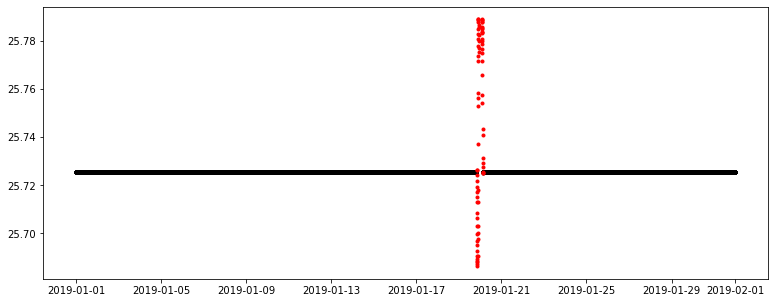

In [10]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'r.')

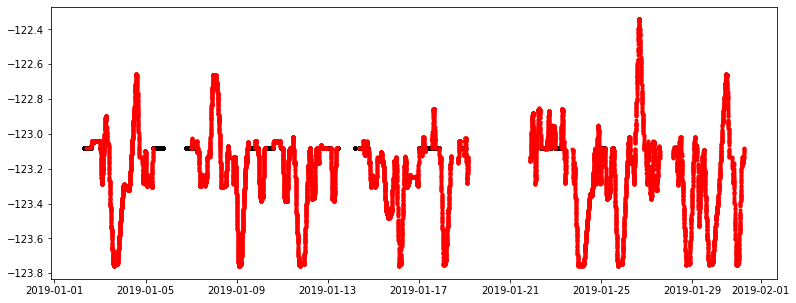

In [102]:
indices = labels == 0

fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'r.')

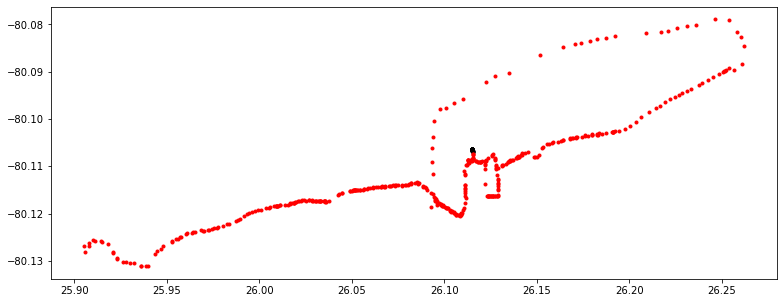

In [324]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'r.')

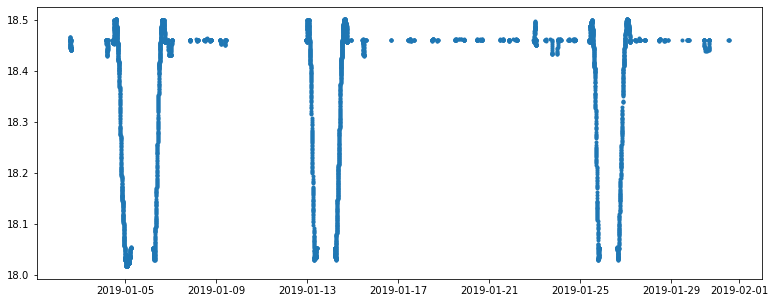

In [240]:
indices = labels == -1
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], '.')

Number of clusters: 27
Number of Noise Points: 4293


In [225]:
len(clustering.components_) + np.sum(labels == -1)

26874

In [226]:
location.shape

(27296, 2)

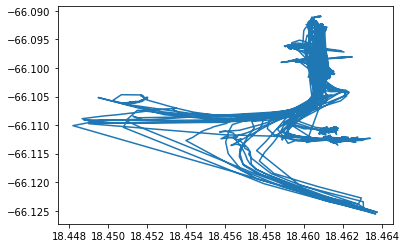

In [163]:
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices])

In [166]:
clustering.core_sample_indices_.shape

(25266,)

In [167]:
location.shape

(27296, 2)

In [127]:
####getting speeds
distance = []
for i in range(1, len(latitude)):
    x = (latitude[i] - latitude[i-1])**2
    y = (longitude[i] - longitude[i-1])**2
    
    distance.append((x+y)**0.5)

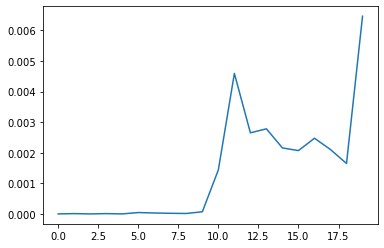

In [131]:
plt.plot(distance[140:160])

In [138]:
dist = np.diff(np.array(distance))

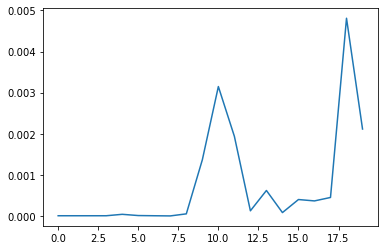

In [140]:
plt.plot(np.abs(dist[140:160]))

In [141]:
dist[140:160]

array([ 1.00000000e-05, -1.00000000e-05,  1.00000000e-05, -1.00000000e-05,
        4.47213595e-05, -1.47213596e-05, -1.00000000e-05, -5.85786438e-06,
        5.58578644e-05,  1.37006944e-03,  3.15062767e-03, -1.94052731e-03,
        1.30279798e-04, -6.24040552e-04, -8.70130050e-05,  4.04083284e-04,
       -3.70695462e-04, -4.54360380e-04,  4.81137527e-03, -2.11817464e-03])

In [122]:
time = []
for i in range(1, len(latitude)):
    time.append((datetime_objects[i] - datetime_objects[i-1]).seconds)

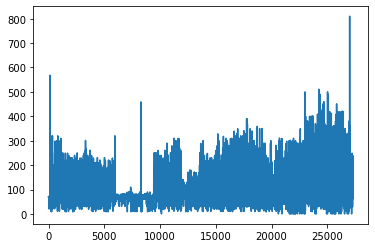

In [123]:
plt.plot(time)

In [126]:
min(time),max(time), np.mean(np.array(time)), np.std(np.array(time))

(0, 810, 93.61263967759663, 45.77165600134406)

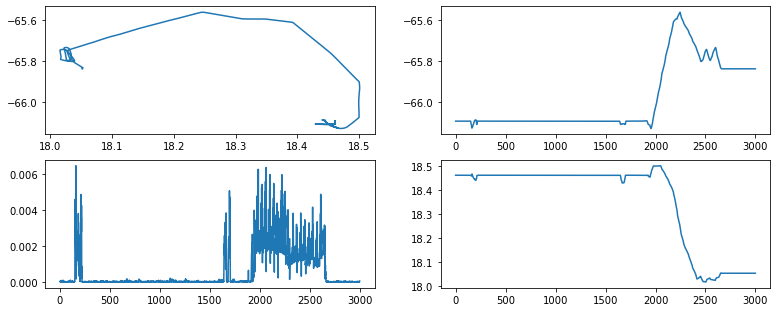

In [192]:
fig = plt.figure(figsize = (13,8))
n = np.arange(0, 3000)

plt.subplot(3, 2, 1)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

plt.subplot(3, 2, 2)
plt.plot(np.array(longitude)[n])

plt.subplot(3, 2, 3)
plt.plot(np.array(distance)[n])

plt.subplot(3, 2, 4)
plt.plot(np.array(latitude)[n])

#plt.subplot(3, 2, 5)
#plt.plot(np.array(latitude)[n], np.array(longitude)[n], '--')

plt.show()

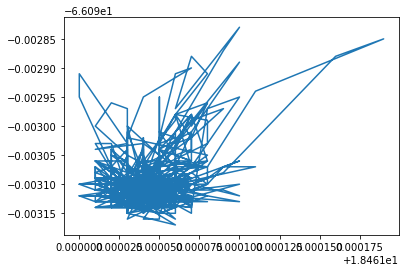

In [187]:
n = np.arange(500, 1500)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

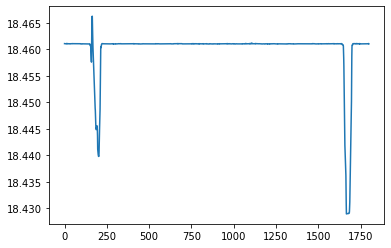

In [184]:
plt.plot(latitude[:n])

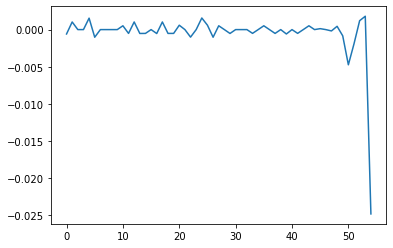

In [121]:
plt.plot(speeds_lat[100:155])

In [78]:
for d in datelist:
    print(d)

2019-01-03T00:26:54
2019-01-06T01:47:56
2019-01-16T19:20:21
2019-01-18T11:36:34
2019-01-19T01:25:48
2019-01-21T12:21:36
2019-01-23T04:07:36
2019-01-25T09:41:41
2019-01-27T02:02:54
2019-01-04T15:33:18
2019-01-06T09:42:44
2019-01-08T16:57:51
2019-01-10T08:47:15
2019-01-26T03:24:47
2019-01-04T17:53:43
2019-01-06T05:19:52
2019-01-07T06:50:45
2019-01-20T13:23:51
2019-01-20T13:38:51
2019-01-08T13:15:51
2019-01-14T04:08:58
2019-01-16T06:31:00
2019-01-20T13:44:52
2019-01-23T05:26:48
2019-01-27T22:04:50
2019-01-31T16:21:26
2019-01-01T18:47:43
2019-01-03T07:51:21
2019-01-12T12:39:12
2019-01-15T20:28:32
2019-01-28T04:47:27
2019-01-16T17:08:21
2019-01-23T00:05:40
2019-01-05T15:01:52
2019-01-12T09:59:45
2019-01-13T07:00:44
2019-01-15T00:53:23
2019-01-15T14:38:11
2019-01-17T23:29:23
2019-01-20T20:43:39
2019-01-21T03:46:54
2019-01-21T04:39:49
2019-01-23T14:38:46
2019-01-24T16:36:18
2019-01-30T22:16:36
2019-01-12T14:50:11
2019-01-15T16:52:33
2019-01-22T07:18:13
2019-01-25T12:11:41
2019-01-26T08:44:49


2019-01-29T09:36:31
2019-01-29T21:34:05
2019-01-31T08:54:26
2019-01-02T22:50:54
2019-01-07T14:38:03
2019-01-12T15:50:07
2019-01-12T11:26:19
2019-01-13T03:11:48
2019-01-14T08:22:53
2019-01-22T04:51:12
2019-01-25T21:42:06
2019-01-25T21:05:36
2019-01-27T22:07:18
2019-01-31T10:36:26
2019-01-31T03:42:29
2019-01-10T04:15:28
2019-01-11T04:32:23
2019-01-19T21:41:34
2019-01-20T20:55:38
2019-01-22T03:15:14
2019-01-25T06:35:41
2019-01-25T07:35:41
2019-01-31T18:45:26
2019-01-03T05:09:20
2019-01-16T10:09:58
2019-01-16T18:53:22
2019-01-26T21:06:33
2019-01-29T16:32:51
2019-01-02T09:37:03
2019-01-02T06:25:03
2019-01-03T02:36:23
2019-01-05T08:40:12
2019-01-09T00:57:28
2019-01-11T17:50:15
2019-01-22T14:53:10
2019-01-26T11:38:48
2019-01-31T00:24:33
2019-01-06T20:51:52
2019-01-07T17:46:34
2019-01-13T01:42:28
2019-01-16T18:50:24
2019-01-20T10:28:42
2019-01-21T14:00:33
2019-01-25T12:32:43
2019-01-30T20:59:41
2019-01-07T13:53:03
2019-01-07T23:34:27
2019-01-13T15:42:31
2019-01-21T14:05:00
2019-01-23T09:29:46


2019-01-16T17:29:21
2019-01-16T16:08:22
2019-01-23T10:35:44
2019-01-26T17:46:29
2019-01-03T08:40:16
2019-01-07T09:29:08
2019-01-11T07:02:15
2019-01-15T06:35:23
2019-01-18T05:26:38
2019-01-18T08:57:34
2019-01-23T16:00:11
2019-01-01T08:29:18
2019-01-06T04:46:51
2019-01-07T03:50:51
2019-01-08T23:24:29
2019-01-08T04:01:12
2019-01-03T13:17:11
2019-01-04T07:33:00
2019-01-07T05:02:46
2019-01-15T07:32:26
2019-01-19T05:34:47
2019-01-21T01:21:20
2019-01-31T02:03:29
2019-01-03T17:29:11
2019-01-09T10:37:23
2019-01-10T10:02:15
2019-01-11T20:20:15
2019-01-13T00:51:27
2019-01-14T00:18:21
2019-01-21T09:28:38
2019-01-22T16:04:06
2019-01-24T09:18:29
2019-01-25T16:59:57
2019-01-01T18:59:42
2019-01-06T01:20:36
2019-01-10T19:20:21
2019-01-14T16:20:25
2019-01-16T10:53:55
2019-01-31T10:42:26
2019-01-10T17:04:29
2019-01-13T10:41:10
2019-01-18T08:24:35
2019-01-19T00:19:52
2019-01-25T18:16:22
2019-01-28T12:39:09
2019-01-08T08:16:34
2019-01-17T06:48:50
2019-01-22T19:49:49
2019-01-22T13:45:14
2019-01-24T05:44:11


2019-01-15T18:25:33
2019-01-22T01:39:12
2019-01-28T08:27:08
2019-01-30T12:16:19
2019-01-31T05:30:27
2019-01-31T13:15:25
2019-01-31T04:30:25
2019-01-01T09:23:18
2019-01-03T06:00:22
2019-01-08T05:55:12
2019-01-14T08:10:53
2019-01-15T06:29:25
2019-01-16T06:21:58
2019-01-18T23:07:51
2019-01-23T10:05:44
2019-01-24T13:12:21
2019-01-28T01:05:52
2019-01-06T12:15:42
2019-01-24T21:31:38
2019-01-27T03:59:44
2019-01-07T16:31:32
2019-01-12T10:13:36
2019-01-14T09:52:35
2019-01-15T00:47:23
2019-01-19T07:16:47
2019-01-19T07:28:46
2019-01-25T04:35:12
2019-01-27T21:31:50
2019-01-05T06:25:46
2019-01-19T16:01:37
2019-01-20T23:12:24
2019-01-27T05:38:46
2019-01-29T03:36:13
2019-01-05T08:31:13
2019-01-06T23:38:45
2019-01-10T08:41:16
2019-01-16T12:20:55
2019-01-17T01:27:17
2019-01-19T13:49:37
2019-01-24T17:06:18
2019-01-28T17:34:43
2019-01-29T00:03:13
2019-01-30T08:37:19
2019-01-05T22:01:44
2019-01-07T20:10:26
2019-01-10T08:14:15
2019-01-14T13:56:26
2019-01-18T17:32:07
2019-01-20T02:16:04
2019-01-23T20:44:36


2019-01-01T22:10:44
2019-01-06T05:31:17
2019-01-10T22:25:13
2019-01-12T11:18:54
2019-01-14T23:38:24
2019-01-17T09:18:47
2019-01-21T18:27:14
2019-01-26T13:38:34
2019-01-05T08:43:38
2019-01-10T13:26:20
2019-01-10T02:12:30
2019-01-14T19:23:27
2019-01-14T07:45:24
2019-01-30T08:31:19
2019-01-02T09:55:04
2019-01-05T09:54:56
2019-01-05T23:22:43
2019-01-06T07:12:42
2019-01-10T03:36:30
2019-01-10T18:58:26
2019-01-10T01:57:28
2019-01-14T08:25:20
2019-01-16T15:14:21
2019-01-27T05:29:44
2019-01-13T05:24:42
2019-01-14T06:17:57
2019-01-17T05:30:15
2019-01-23T17:26:36
2019-01-27T06:53:45
2019-01-28T13:27:08
2019-01-31T17:57:25
2019-01-09T17:30:02
2019-01-10T12:11:03
2019-01-12T05:49:55
2019-01-15T14:50:11
2019-01-20T04:19:04
2019-01-26T20:55:36
2019-01-10T16:46:31
2019-01-13T05:00:42
2019-01-17T20:23:24
2019-01-19T16:40:37
2019-01-21T11:36:33
2019-01-22T08:51:13
2019-01-26T20:58:06
2019-01-30T11:46:20
2019-01-08T22:21:31
2019-01-24T00:55:48
2019-01-31T04:21:26
2019-01-16T07:48:58
2019-01-19T04:52:47


2019-01-21T20:48:14
2019-01-27T15:40:29
2019-01-27T23:10:14
2019-01-04T21:39:30
2019-01-05T10:37:52
2019-01-06T22:34:20
2019-01-06T08:27:42
2019-01-11T23:08:28
2019-01-17T10:27:47
2019-01-19T16:37:36
2019-01-06T01:04:09
2019-01-08T11:50:31
2019-01-09T16:16:18
2019-01-12T13:25:58
2019-01-17T08:03:48
2019-01-22T13:00:12
2019-01-27T05:26:45
2019-01-28T08:54:09
2019-01-05T08:22:43
2019-01-10T15:37:29
2019-01-10T23:44:31
2019-01-17T17:30:58
2019-01-17T20:53:24
2019-01-31T18:12:26
2019-01-05T10:12:56
2019-01-11T18:20:15
2019-01-22T04:36:13
2019-01-29T08:08:09
2019-01-29T22:25:09
2019-01-30T14:37:15
2019-01-31T15:15:27
2019-01-06T09:39:43
2019-01-14T19:02:26
2019-01-18T03:47:40
2019-01-21T06:49:44
2019-01-28T19:33:14
2019-01-31T04:24:25
2019-01-04T19:11:07
2019-01-05T21:55:47
2019-01-19T21:27:13
2019-01-23T01:05:42
2019-01-26T13:08:47
2019-01-27T00:56:00
2019-01-31T14:12:26
2019-01-10T04:30:18
2019-01-14T20:56:24
2019-01-21T15:09:25
2019-01-22T01:36:13
2019-01-23T20:38:37
2019-01-25T08:59:41


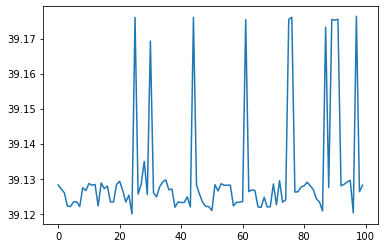

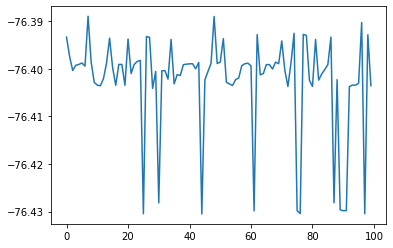

In [63]:
plt.plot(longitude[:100])

In [29]:
datelist[0],datelist[-1] 

('2019-01-01T00:00:06', '2019-01-31T23:59:26')

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(builtins.object)
 |  DataFrame(jdf, sql_ctx)
 |  
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the data frame, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .groupBy(department.name, "gender").agg({"salary": "avg", "age